In [60]:
import os
import pandas as pd
import numpy as np
import mysql.connector
from dotenv import load_dotenv
import seaborn as sns
from scipy import stats
from statsmodels.tsa.seasonal import seasonal_decompose

In [61]:
import matplotlib.pyplot as plt
plt.rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False

In [62]:
# DB 연결
load_dotenv()

conn = mysql.connector.connect(
    host=os.getenv("DB_HOST"),
    user=os.getenv("DB_USER"),
    password=os.getenv("DB_PASSWORD"),
    database="suwon_business"
)

cursor = conn.cursor()

In [63]:
# 쿼리 정의
query = """
SELECT
    t.transaction_date,
    t.district_code,
    d.name AS district_name,
    t.time_block_code,
    t.gender,
    t.age_group_code,
    t.day_of_week,
    t.transaction_amount,
    t.transaction_count,
    w.avg_temp,
    w.max_temp,
    w.min_temp
FROM card_transaction t
JOIN district d ON t.district_code = d.district_id
JOIN weather w ON t.transaction_date = w.weather_date AND t.district_code = w.district_id
"""

df = pd.read_sql(query, conn)
conn.close()

df

/var/folders/36/pdpmp_4s2wv687klck6zglrm0000gn/T/ipykernel_60962/260202010.py:21: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


,transaction_date,district_code,district_name,time_block_code,gender,age_group_code,day_of_week,transaction_amount,transaction_count,avg_temp,max_temp,min_temp
0,2024-08-01,41111,장안구,1,F,3,4,19556,3,29.2290,33.5963,24.861700
1,2024-08-01,41111,장안구,1,M,2,4,4010,2,29.2290,33.5963,24.861700
2,2024-08-01,41111,장안구,1,M,3,4,14393,3,29.2290,33.5963,24.861700
3,2024-08-01,41111,장안구,1,M,4,4,876,2,29.2290,33.5963,24.861700
4,2024-08-01,41111,장안구,1,M,5,4,939,2,29.2290,33.5963,24.861700
...,...,...,...,...,...,...,...,...,...,...,...,...
1603317,2025-03-31,41117,영통구,10,F,4,1,17503,2,8.0829,15.6633,0.502481
1603318,2025-03-31,41117,영통구,10,F,6,1,102472,2,8.0829,15.6633,0.502481
1603319,2025-03-31,41117,영통구,10,M,3,1,3442,2,8.0829,15.6633,0.502481
1603320,2025-03-31,41117,영통구,10,M,5,1,135210,3,8.0829,15.6633,0.502481


In [64]:
df.columns

Index(['transaction_date', 'district_code', 'district_name', 'time_block_code',
       'gender', 'age_group_code', 'day_of_week', 'transaction_amount',
       'transaction_count', 'avg_temp', 'max_temp', 'min_temp'],
      dtype='object')

In [65]:
df.count()

transaction_date      1603322
district_code         1603322
district_name         1603322
time_block_code       1603322
gender                1603322
age_group_code        1603322
day_of_week           1603322
transaction_amount    1603322
transaction_count     1603322
avg_temp              1603322
max_temp              1603322
min_temp              1603322
dtype: int64

In [66]:
df.info

<bound method DataFrame.info of         transaction_date  district_code district_name  time_block_code gender  \
0             2024-08-01          41111           장안구                1      F   
1             2024-08-01          41111           장안구                1      M   
2             2024-08-01          41111           장안구                1      M   
3             2024-08-01          41111           장안구                1      M   
4             2024-08-01          41111           장안구                1      M   
...                  ...            ...           ...              ...    ...   
1603317       2025-03-31          41117           영통구               10      F   
1603318       2025-03-31          41117           영통구               10      F   
1603319       2025-03-31          41117           영통구               10      M   
1603320       2025-03-31          41117           영통구               10      M   
1603321       2025-03-31          41117           영통구               10      M

In [67]:
df.isnull().mean().sort_values(ascending=False)

transaction_date      0.0
district_code         0.0
district_name         0.0
time_block_code       0.0
gender                0.0
age_group_code        0.0
day_of_week           0.0
transaction_amount    0.0
transaction_count     0.0
avg_temp              0.0
max_temp              0.0
min_temp              0.0
dtype: float64

In [68]:
df.describe()

,district_code,time_block_code,age_group_code,day_of_week,transaction_amount,transaction_count,avg_temp,max_temp,min_temp
count,1.603322e+06,1.603322e+06,1.603322e+06,1.603322e+06,1.603322e+06,1.603322e+06,1.603322e+06,1.603322e+06,1.603322e+06
mean,4.111411e+04,5.464615e+00,5.050107e+00,3.999974e+00,1.773111e+05,1.976734e+01,1.407041e+01,1.897826e+01,9.162558e+00
std,2.268238e+00,2.490763e+00,1.803883e+00,1.995954e+00,4.587060e+05,3.464352e+01,1.073996e+01,1.081094e+01,1.092608e+01
min,4.111100e+04,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,2.000000e+00,-1.024200e+01,-7.687200e+00,-1.353520e+01
25%,4.111300e+04,3.000000e+00,4.000000e+00,2.000000e+00,1.595700e+04,3.000000e+00,3.514100e+00,8.685690e+00,-1.174090e+00
50%,4.111500e+04,5.000000e+00,5.000000e+00,4.000000e+00,5.194000e+04,8.000000e+00,1.584370e+01,2.152600e+01,9.902900e+00
75%,4.111700e+04,8.000000e+00,6.000000e+00,6.000000e+00,1.595068e+05,2.000000e+01,2.359820e+01,2.786330e+01,1.917180e+01
max,4.111700e+04,1.000000e+01,1.100000e+01,7.000000e+00,5.460398e+07,1.009000e+03,3.020880e+01,3.512770e+01,2.625530e+01


In [69]:
df.shape

(1603322, 12)

In [70]:
# 상관계수 계산
correlation_vars = ['transaction_amount', 'transaction_count', 'avg_temp', 'max_temp', 'min_temp', 'temp_diff']
correlation_matrix = df[correlation_vars].corr()

# 상관계수 히트맵
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0,
            square=True, fmt='.3f')
plt.title('변수간 상관관계 히트맵')
plt.show()


# 통계적 유의성 검정
print("📈 통계적 유의성 검정")
temp_amount_corr, temp_amount_p = stats.pearsonr(df['avg_temp'], df['transaction_amount'])
print(f"평균기온-매출 상관계수: {temp_amount_corr:.4f} (p-value: {temp_amount_p:.6f})")

temp_count_corr, temp_count_p = stats.pearsonr(df['avg_temp'], df['transaction_count'])
print(f"평균기온-거래건수 상관계수: {temp_count_corr:.4f} (p-value: {temp_count_p:.6f})")
print()

KeyError: "['temp_diff'] not in index"

In [50]:
# 통계적 유의성 검정
print("📈 통계적 유의성 검정")
temp_amount_corr, temp_amount_p = stats.pearsonr(df['avg_temp'], df['transaction_amount'])
print(f"평균기온-매출 상관계수: {temp_amount_corr:.4f} (p-value: {temp_amount_p:.6f})")

temp_count_corr, temp_count_p = stats.pearsonr(df['avg_temp'], df['transaction_count'])
print(f"평균기온-거래건수 상관계수: {temp_count_corr:.4f} (p-value: {temp_count_p:.6f})")
print()

📈 통계적 유의성 검정
평균기온-매출 상관계수: 0.0064 (p-value: 0.000000)
평균기온-거래건수 상관계수: 0.0351 (p-value: 0.000000)



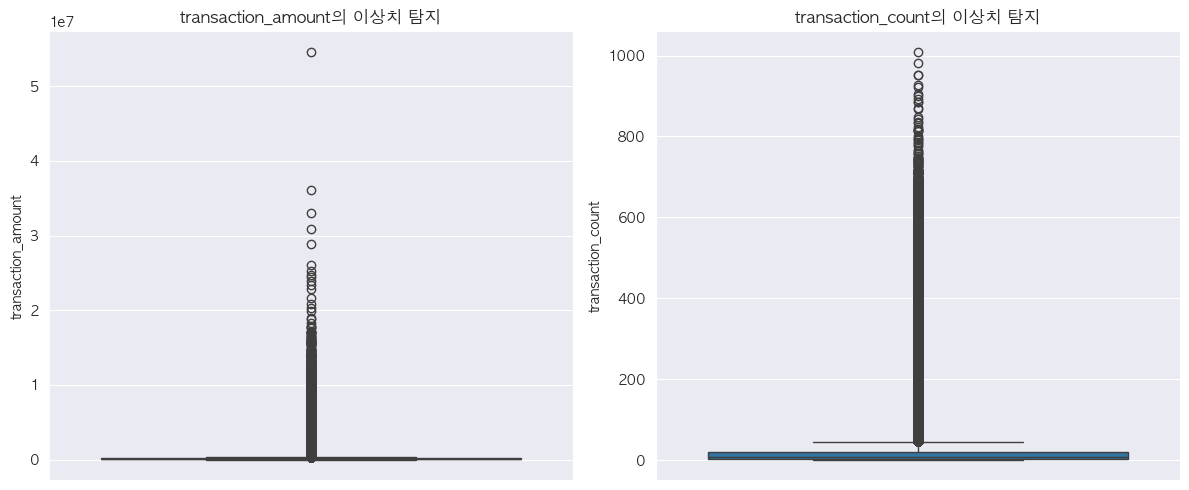

In [56]:
plt.figure(figsize=(12, 5))
for i, col in enumerate(['transaction_amount', 'transaction_count']):
    plt.subplot(1, 2, i+1)
    sns.boxplot(y=df[col])
    plt.title(f'{col}의 이상치 탐지')
plt.tight_layout()
plt.show()

In [57]:
def remove_outliers_iqr(df, columns):
    mask = pd.Series([True] * len(df))
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        mask &= df[col].between(lower_bound, upper_bound)
    return df[mask]

In [58]:
target_cols = ['transaction_amount', 'transaction_count']

# 이상치 제거된 데이터프레임 생성
df_no_outliers = remove_outliers_iqr(df, target_cols)

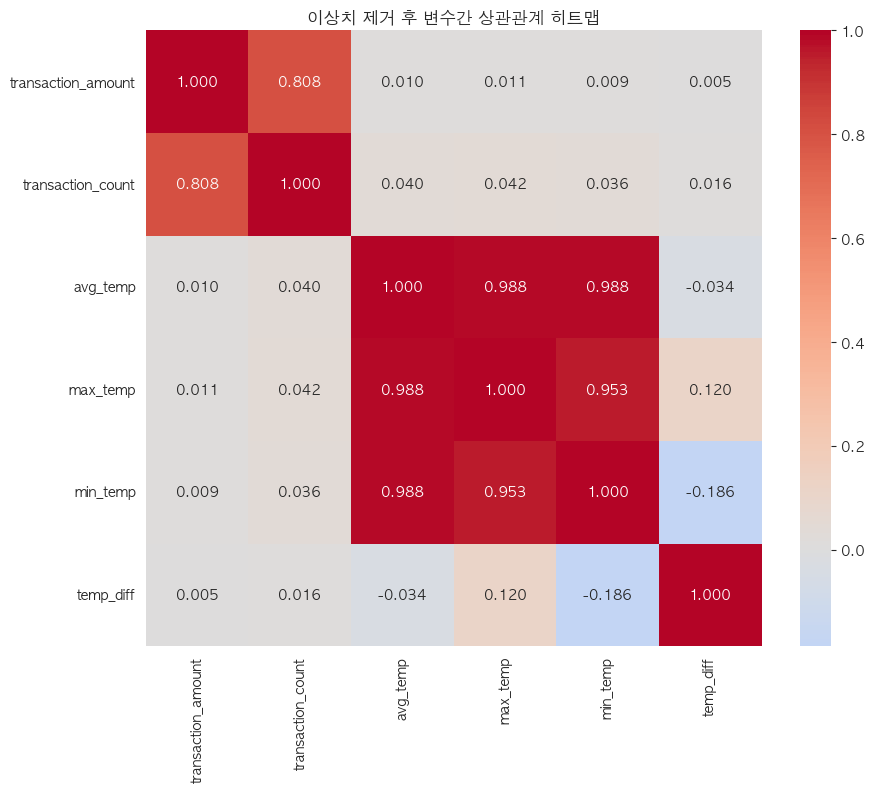

In [59]:
correlation_vars = ['transaction_amount', 'transaction_count',
                    'avg_temp', 'max_temp', 'min_temp', 'temp_diff']

# 상관계수 계산
correlation_matrix = df_no_outliers[correlation_vars].corr()

# 히트맵 시각화
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0,
            square=True, fmt='.3f')
plt.title('이상치 제거 후 변수간 상관관계 히트맵')
plt.show()